# Classement de spams par réseaux de neurones

Dans cet exercice, le but est de créer un systèmes très basique de classement de spam par Réseaux de Neurones en se basant uniquement sur des mots clés trouvés dans les sujets de mails.

Une version plus évoluée étudierait aussi le texte transormé en sac de mots.


---
*Devant la masse de mails reçus, un système de classement automatique basé sur les mots clés des sujets pourrait aider à les gérer.*

*Il s’agit donc ici de définir un réseau de neurones et de lui faire apprendre à classer des textes.*

---

Les exemples d’apprentissage seront constitués :
- d’une série de valeurs indiquant si oui ou non un terme est présent dans le texte analysé,
- de la réponse attendue (classement dans une des trois catégories choisies)

Voici les exemples d’apprentissage :


| meilleur   |  cadeau  |  loto  |  gratuit  |  algo  |  agent  | java | code | rando | restaurant | cine | vacances | *spam* | *perso* | *boulot* |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:| 
| 1 | 1 |  | 1 |  |  |  |  |  |  |  |  | 1 |  | | 
|  |  | 1 |  |  |  |  |  |  |  |  |  | 1 |  | | 
|  | 1 |  |  |  |  |  |  |  | 1 |  |  | 1 |  | | 
|  | 1 |  | 1 |  |  |  |  |  |  |  |  | 1 |  | | 
|  |  |  | 1 |  |  |  |  |  |  |  | 1 | 1 |  | | 
|  |  | 1 |  |  |  |  |  |  |  |  | 1 | 1 |  | | 
|  | 1 |  |  |  |  |  | 1 |  |  |  |  |  | 1 | | 
|  |  |  |  |  |  |  |  |  |  | 1 |  |  | 1 | | 
| 1 |  |  |  |  |  |  |  |  | 1 |  |  |  | 1 | | 
| 1 |  |  |  |  |  |  |  |  |  | 1 |  |  | 1 | | 
|  |  |  |  |  |  |  |  | 1 |  |  |  |  | 1 | | 
|  |  |  |  | 1 |  |  | 1 |  |  |  |  |  |  | 1| 
|  |  |  |  |  | 1 |  |  |  |  |  |  |  |  | 1| 
| 1 |  |  |  | 1 |  |  |  |  |  |  |  |  |  | 1| 
|  |  |  |  | 1 |  | 1 |  |  |  |  |  |  |  | 1| 


---
## Importer les librairires

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
#pour les graphiques
import matplotlib.pyplot as plt
#SI bug plus loin lors du dessin des graphiques, ajouter ces 2 lignes
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

---

### Définir les entrées et sorties attendues

Les entrées correspondent aux présente des mots clés par sujet de mail.
Ici, les entrées sont constituées de 15 lignes de  12 valeurs 0,1. 
Les sorties d'apprentissage correspondent donc à 15 lignes de 3 valeurs 0,1 : le fait que chaque entrée soit une des 3 catégories.

On choisit de garder 70% de ces lignes en exemples d'apprentissage.
Les entrées et sorties de validations sont donc constitués des 40% restants

In [6]:
#définissez les entrées sorties sur base du tableau
tableau = np.array([
[ 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[ 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[ 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
[ 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[ 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
[ 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
[ 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
[ 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
[ 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
[ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
[ 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
[ 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[ 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[ 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]], float)

#on prend un pourcentage de lignes pour apprendre, le reste pour valider
#IL FAUT MELANGER LE LIGNES pour pouvoir avoir des exemples d'apprentissage
# et de validation homogènes
np.random.shuffle(tableau)

#on décide que 70% des lignes sont des lignes d'apprentissage
nb_lignes = tableau.shape[0]
nb_lignes_app = nb_lignes * 70 // 100
nb_lignes_val = nb_lignes - nb_lignes_app

# les 12 premieres colonnes sont les entrees
entrees_app = np.zeros((nb_lignes_app, 12), float)
entrees_val = np.zeros((nb_lignes_val, 12), float)

# les 3 dernieres colonnes sont la sortie
sorties_app = np.zeros((nb_lignes_app, 3), float)
sorties_val = np.zeros((nb_lignes_val, 3), float)

#on remplit ces exemples d'apprentissage et de validation
for i in range(0,nb_lignes_app):
    entrees_app[i] = tableau[i][0:12]
    sorties_app[i] = tableau[i][12:]

#on remplit ces exemples de validation
for i in range(0, nb_lignes_val):
    entrees_val[i] = tableau[nb_lignes_app+i][0:12]
    sorties_val[i] = tableau[nb_lignes_app+i][12:]

---

### Choisir le modèle de réseau
- ici les couches sont séquentielles

In [8]:
model = Sequential()

---

### Définir l'architecture du réseau
Choisissez la struture du réseau, le nb de couches cachées, etc.
- une première couche composée de 
  - 12 neurones en entrée , plus le neurone BIAS 
  - 8 neurones en sortie 
- 2 couches intermédiaires de 5 neurones en sortie
- une couche composée
  - 5 neurones en entrée (ceux de la couche précédente) et 
  - de 3 neurone en sortie (les 3 catégories)


In [9]:
avec_bias = True
#une premiere couche constituée de 12 neurones en entrée, ... input_shape=(12,)
model.add(Dense(8, activation='tanh'))

model.add(Dense(5, activation='tanh'))

model.add(Dense(5, activation='tanh'))



#une derniere couche constituée de 1 neurone en sortie 
model.add(Dense(3, activation='sigmoid'))


---

### Compiler le  réseau
- ici, on précise que l'algo de correction d'erreur est *'adam'*, et que l'erreur calculée est la moyenne des valeurs absolues des erreurs commises. On indique également que l'on veut voir apparaître en plus la précision de l'apprentissage (accuracy).
(vous pouvez chosir un autre optimizer et un autre clacul de loss)

In [10]:
model.compile(optimizer='adam', loss='MSE',  metrics=['accuracy'])

---

### Entraîner le réseau 
- ici on  le fait  'parler' (verbose=1), et on lance xx cycles d'apprentissage (epochs à préciser)


In [11]:
tests = model.fit(entrees_app, sorties_app, 
                    validation_data=(entrees_val, sorties_val),
                    epochs=100, verbose=0)

---

## Dessiner l'évolution de l'erreur et de la pertinence


In [12]:
history_dict = tests.history
eval_tests = list(history_dict.keys())
print("les ensembles de valeurs récupérées lors des tests sont ")
print(eval_tests)
print("-> [perte sur exemple d'entrainement, qualité sur exemples d'entrainement,perte sur exemple de validation, qualité sur exemples de validation]")

les ensembles de valeurs récupérées lors des tests sont 
['loss', 'accuracy', 'val_loss', 'val_accuracy']
-> [perte sur exemple d'entrainement, qualité sur exemples d'entrainement,perte sur exemple de validation, qualité sur exemples de validation]


#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

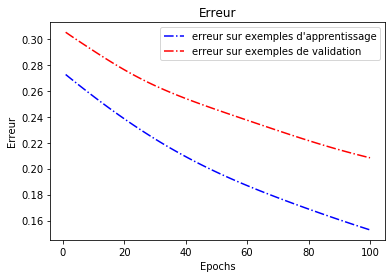

In [13]:
loss = history_dict[eval_tests[0]]
val_loss = history_dict[eval_tests[2]]

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-.', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-.', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

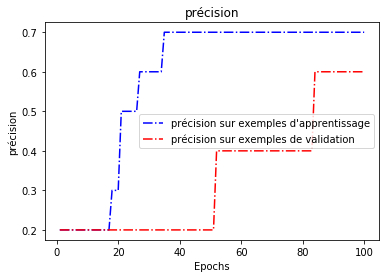

In [14]:
acc = history_dict[eval_tests[1]]
val_acc = history_dict[eval_tests[3]]

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-.', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-.', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

---
## Utilisation du réseau
Quelle est la probabilité que les textes contenant les mots :
1. meilleur cine
2. cine gratuit
3. code agent
4. code cine gratuit
soient des textes suspects ?

In [15]:
entreesTests = np.array([
[1,0,0,0,0,0,0,0,0,0,1,0],
[0,0,0,1,0,0,0,0,0,0,1,0],
[0,0,0,0,0,1,0,1,0,0,0,0],
[0,0,0,1,0,0,0,1,0,0,1,0]], float)
predictions = model.predict(entreesTests)
print(predictions)

[[0.5681091  0.49289703 0.40189752]
 [0.703041   0.47939712 0.13455749]
 [0.3323149  0.27008438 0.55183405]
 [0.6993444  0.4398357  0.12095323]]
